# Brain Tumor Object Detection<br>
Implementing a brain tumor detection system using YOLOv8. Curate a diverse dataset, annotate images, and train models for accurate detection. Emphasizing ethical healthcare data usage, this project seeks robust precision and recall in identifying brain tumors through the YOLOv8 along with different sizes and optimizers.

## **Data Collection**

[Dataset](https://www.kaggle.com/datasets/ammarahmed310/labeled-mri-brain-tumor-dataset)<br>
A comprehensive dataset consisting of brain scans from multiple imaging modalities, including MRI, has been chosen for the training of the YOLOv7 model. The dataset has been carefully selected to provide exposure to a wide variety of clinical situations, including cases of pituitary, meningioma, glioma, and no tumor. The dataset was obtained from Kagle and Hayatabad Medical Complex Peshawar. The specifications of the dataset, consisting of 1594 healthy brain samples, 1321 glioma, 1339 meningioma, and 1457 pituitary brain tumor samples.

## Importing Libraries

In [51]:
!pip install Augmentor
!pip install ultralytics

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/jiangtingfeng/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/Users/jiangtingfeng/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## EDA

In [ ]:
# zip_path = '/content/drive/MyDrive/brain_tumor_object_detection/data/data.zip'
# extract_path = '/content/drive/MyDrive/brain_tumor_object_detection/data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

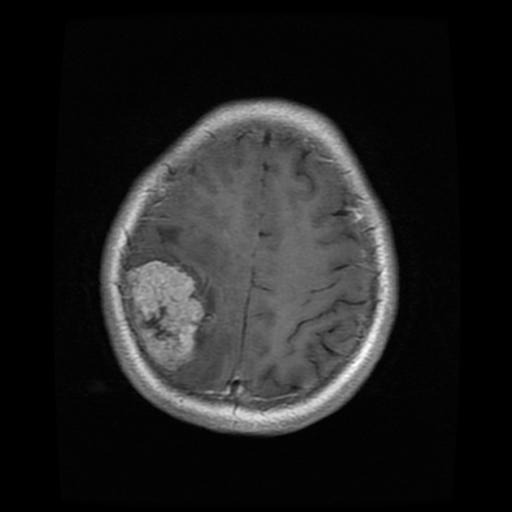

In [5]:
sample_image = Image.open('./Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')
sample_image

In [6]:
sample_image.size

(512, 512)

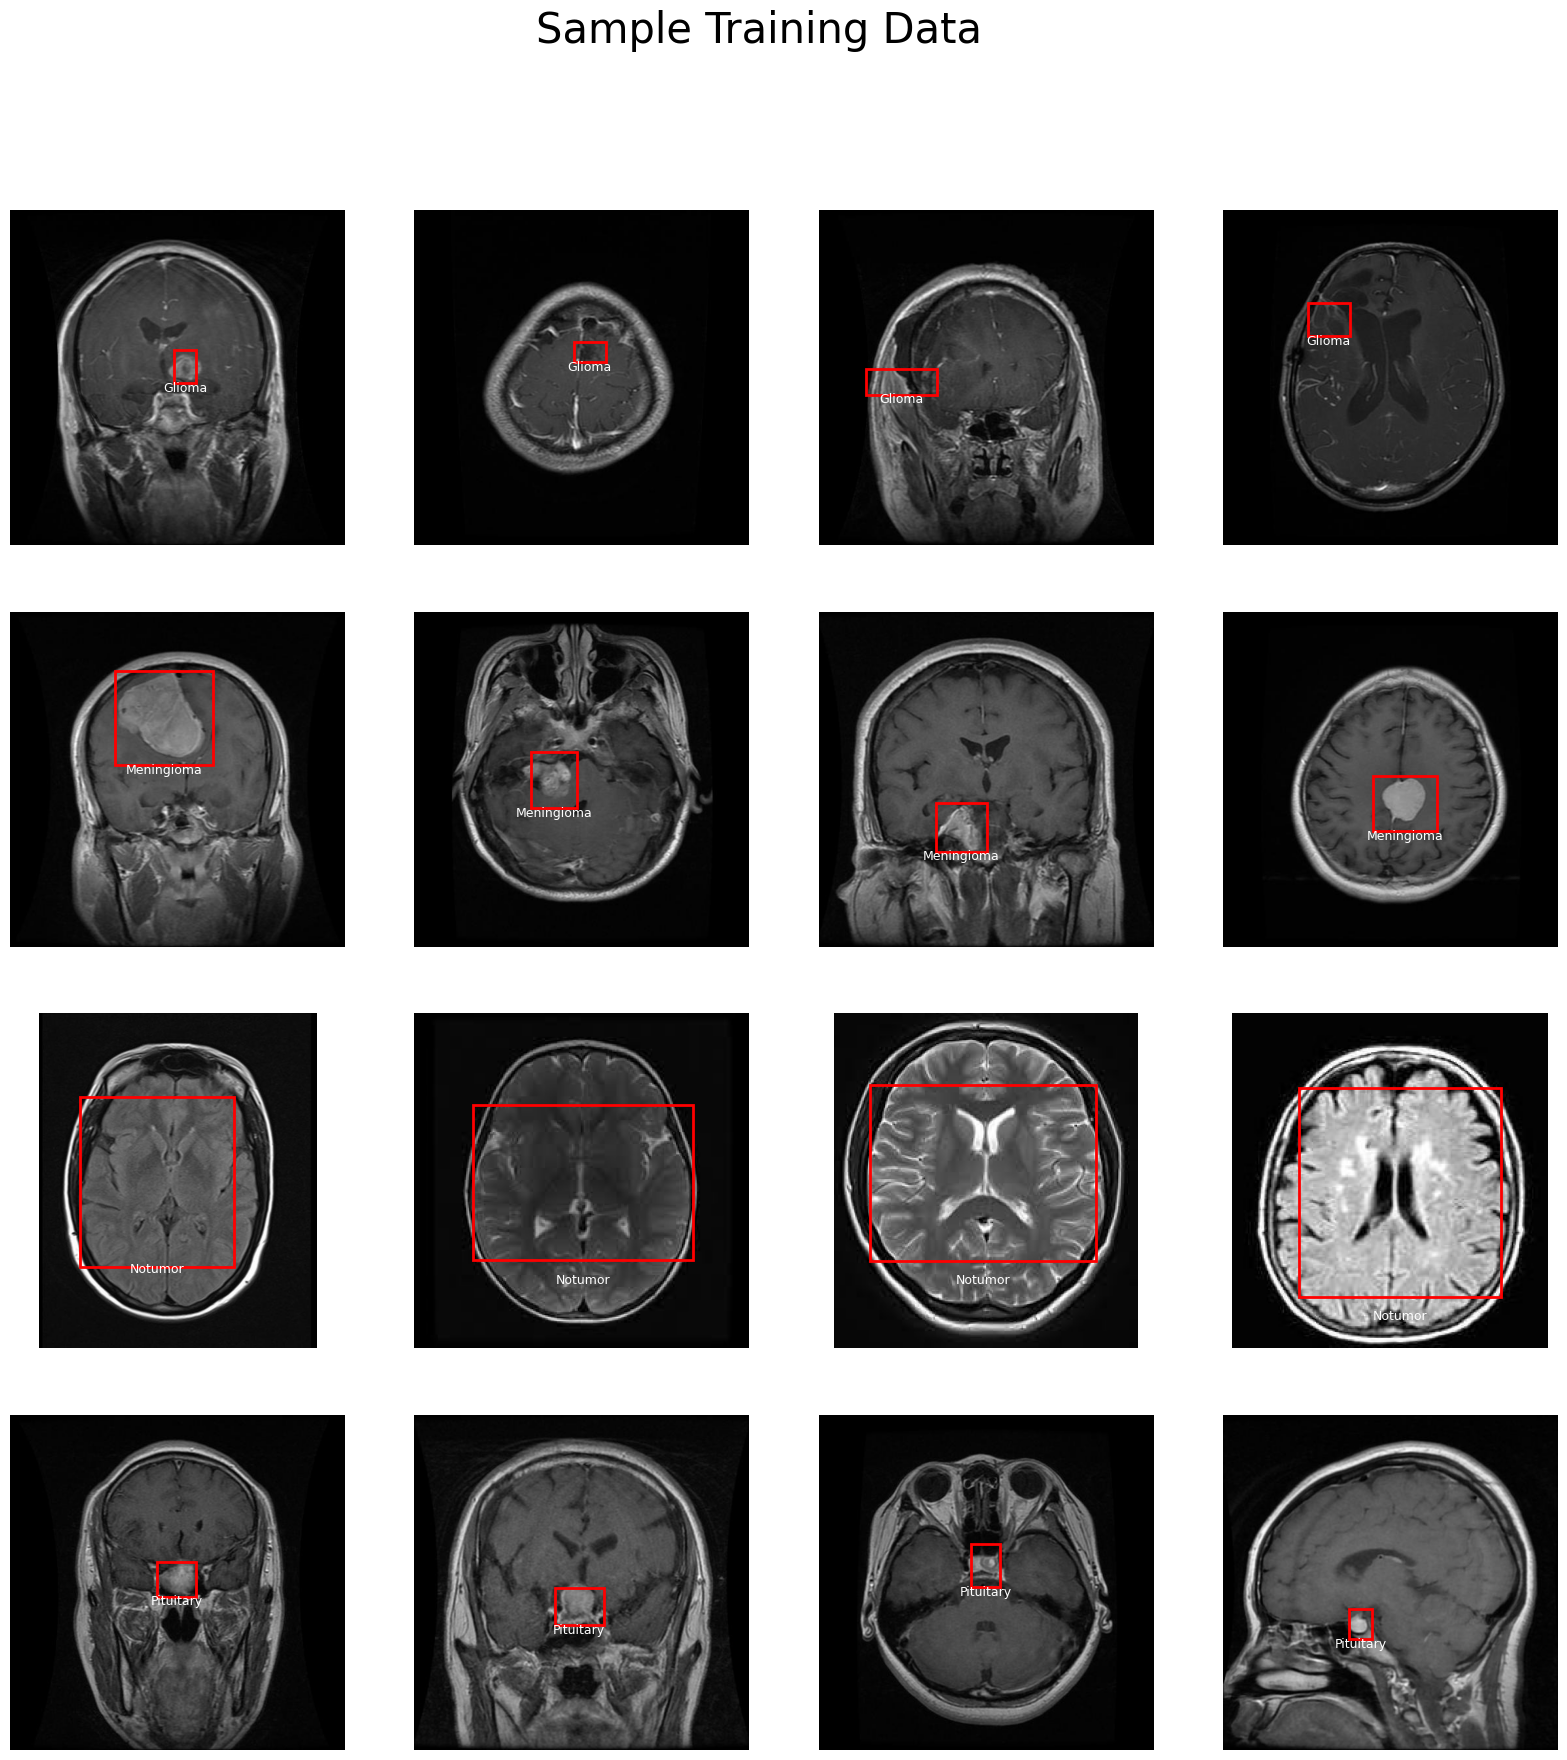

In [8]:
# Plotting the training data with bounding boxes
dataset_directory = './Brain Tumor labeled dataset'
class_labels = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

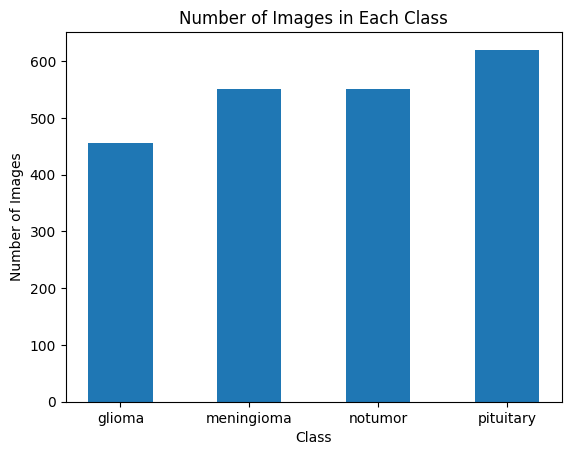

In [9]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

## Train-Test Split

In [10]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [11]:
dataset_directory = './Brain Tumor labeled dataset/'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [12]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [13]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

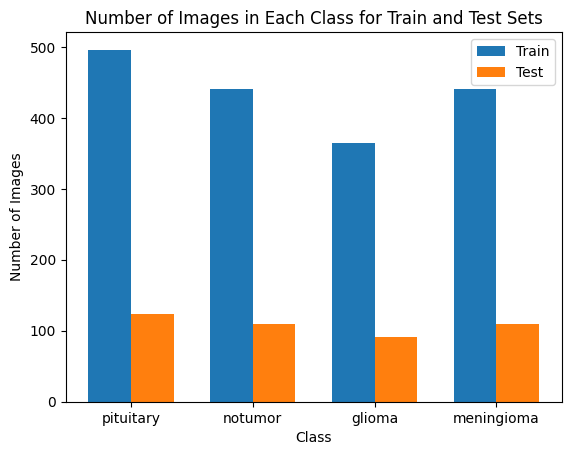

In [14]:
dataset_directory = './Brain Tumor labeled dataset/'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

## YOLOv5n

### Modelling

In [32]:
yolo_btd_model = YOLO('yolov5n.yaml')

yolo_btd_model_results = yolo_btd_model.train(data='brain_tumor_dataset.yaml', epochs=2)

Ultralytics 8.3.58 🚀 Python-3.8.2 torch-2.2.2 CPU (Intel Core(TM) i7-8557U 1.70GHz)
engine/trainer: task=detect, mode=train, model=yolov5n.yaml, data=brain_tumor_dataset.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv


train: New cache created: /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/train/glioma.cache


val: Scanning /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-

val: New cache created: /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/glioma.cache


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train14
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      3.456      4.993      4.056         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        435        439      0.755      0.103    0.00509    0.00128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      3.052      4.374      3.431         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        435        439      0.387      0.138     0.0777     0.0221



2 epochs completed in 0.598 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 5.3MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.8.2 torch-2.2.2 CPU (Intel Core(TM) i7-8557U 1.70GHz)
YOLOv5n summary (fused): 193 layers, 2,503,724 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        435        439      0.387      0.137     0.0775      0.022
                glioma        124        124      0.102      0.202     0.0953     0.0263
            meningioma        110        110      0.185        0.2     0.0891     0.0289
               notumor         92         96          1          0          0          0
             pituitary        109        109      0.259      0.147      0.126     0.0329
Speed: 3.1ms preprocess, 153.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train14


### Performance Metrics

In [33]:
def plot_images(image_paths):
    fig, axes = plt.subplots(len(image_paths), 1, figsize=(80, 80))

    for i, ax in enumerate(axes):
        image_path = image_paths[i]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(os.path.basename(image_path))

    plt.tight_layout()
    plt.show()

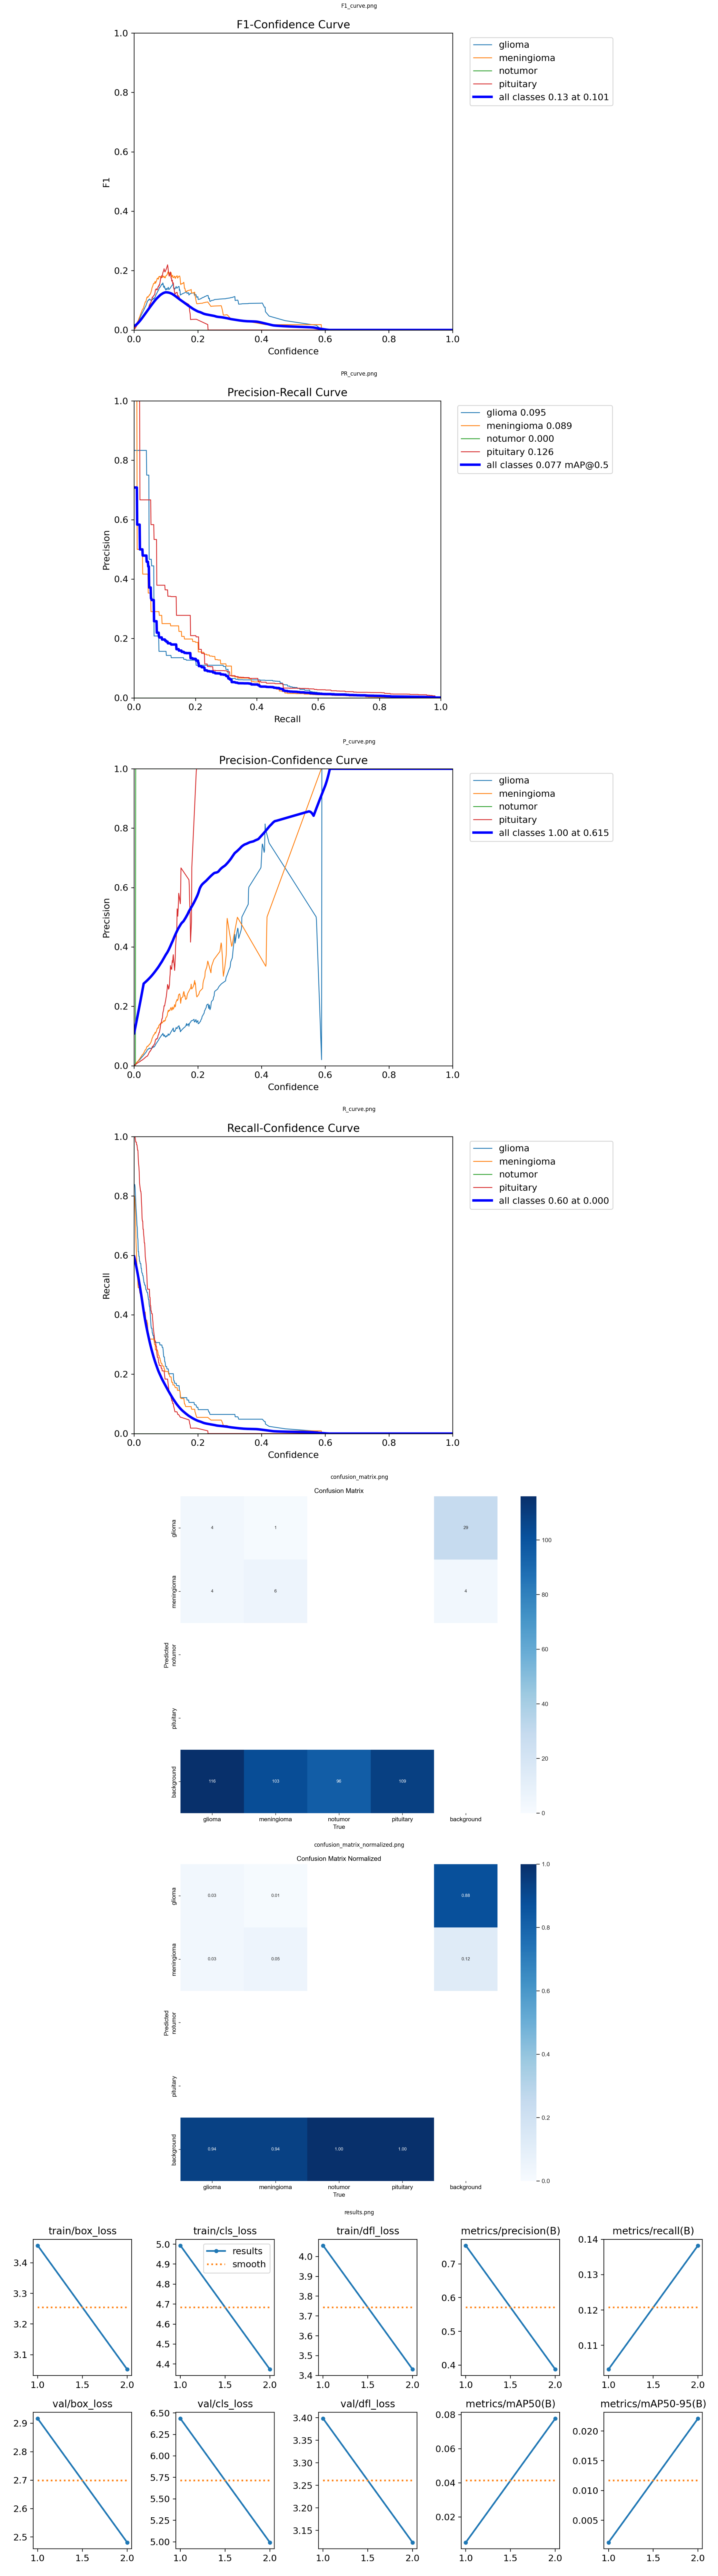

In [34]:
image_paths = [
    './runs/detect/train14/F1_curve.png',
    './runs/detect/train14/PR_curve.png',
    './runs/detect/train14/P_curve.png',
    './runs/detect/train14/R_curve.png',
    './runs/detect/train14/confusion_matrix.png',
    './runs/detect/train14/confusion_matrix_normalized.png',
    './runs/detect/train14/results.png',
]
plot_images(image_paths)

### Testing

In [39]:
def predict_results(test_images_dir):
    model = YOLO('./runs/detect/train14/weights/best.pt')
    # os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=320, conf=0.3)

In [49]:
glioma_test_dir = './Brain Tumor labeled dataset/test/glioma'
predict_results(glioma_test_dir)


image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/glioma/Tr-gl_0559.jpg: 320x320 (no detections), 76.2ms
Speed: 1.1ms preprocess, 76.2ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/glioma/Tr-gl_0405.jpg: 320x320 (no detections), 53.9ms
Speed: 1.2ms preprocess, 53.9ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/glioma/Tr-gl_0377.jpg: 320x320 (no detections), 50.8ms
Speed: 0.8ms preprocess, 50.8ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain 

In [50]:
meningioma_test_dir = './Brain Tumor labeled dataset/test/meningioma'
predict_results(meningioma_test_dir)


image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/meningioma/Tr-me_0368.jpg: 320x320 (no detections), 80.7ms
Speed: 2.3ms preprocess, 80.7ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/meningioma/Tr-me_0354.jpg: 320x320 (no detections), 65.9ms
Speed: 2.1ms preprocess, 65.9ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/meningioma/Tr-me_0383.jpg: 320x320 (no detections), 51.0ms
Speed: 0.7ms preprocess, 51.0ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict2

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOL

In [43]:
notumor_test_dir = './Brain Tumor labeled dataset/test/notumor'
predict_results(notumor_test_dir)


image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/notumor/Tr-no_0029.jpg: 320x320 (no detections), 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict4

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/notumor/Tr-no_0559.jpg: 320x320 (no detections), 49.6ms
Speed: 0.8ms preprocess, 49.6ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict4

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/notumor/Tr-no_0439.jpg: 224x320 (no detections), 36.6ms
Speed: 1.0ms preprocess, 36.6ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 320)
Results saved to runs/detect/predict4

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/

In [44]:
pituitary_test_dir = './Brain Tumor labeled dataset/test/pituitary'
predict_results(pituitary_test_dir)


image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0277.jpg: 320x320 (no detections), 65.2ms
Speed: 1.7ms preprocess, 65.2ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict5

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0061.jpg: 320x320 (no detections), 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict5

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-main/Brain Tumor labeled dataset/test/pituitary/Tr-pi_0129.jpg: 320x320 (no detections), 53.7ms
Speed: 0.8ms preprocess, 53.7ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/predict5

image 1/1 /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8

In [45]:
# # Testing on video
# VIDEOS_DIR = os.path.join('.', 'videos')

# video_path = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test/test_video.mp4'
# video_path_out = '{}_out.mp4'.format(video_path)

# cap = cv2.VideoCapture(video_path)
# ret, frame = cap.read()
# H, W, _ = frame.shape
# out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

# threshold = 0.5

# while ret:

#     results = yolo_btd_model(frame)[0]

#     for result in results.boxes.data.tolist():
#         x1, y1, x2, y2, score, class_id = result

#         if score > threshold:
#             cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
#             cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

#     out.write(frame)
#     ret, frame = cap.read()

# cap.release()
# out.release()
# cv2.destroyAllWindows()

In [46]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

In [47]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [48]:
dirs = ['./test_results_on_all_images/glioma/detect/predict',
        './test_results_on_all_images/meningioma/detect/predict',
        './test_results_on_all_images/notumor/detect/predict',
        './test_results_on_all_images/pituitary/detect/predict']

all_images = []
for directory in dirs:
    random_images = get_random_images_from_dir(directory, num_images=5)
    all_images.extend(random_images)

display_images(all_images)

FileNotFoundError: [Errno 2] No such file or directory: './test_results_on_all_images/glioma/detect/predict'

## YOLOv8n Adamax

### Modelling

In [53]:
yolov8n_btd_model_adamax = YOLO('yolov5n.yaml')
yolov8n_btd_model_adamax_results = yolov8n_btd_model_adamax.train(data = './brain_tumor_dataset.yaml',
                                                    epochs = 2,
                                                    batch = 4,
                                                    name = 'YOLOv5n_Adamax',
                                                    optimizer = 'Adamax',
                                                    lr0 = 0.001,
                                                    lrf = 0.001,
                                                    momentum = 0.85,
                                                    dropout = 0.5
                                                    )

Ultralytics 8.3.58 🚀 Python-3.8.2 torch-2.2.2 CPU (Intel Core(TM) i7-8557U 1.70GHz)
engine/trainer: task=detect, mode=train, model=yolov5n.yaml, data=./brain_tumor_dataset.yaml, epochs=2, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOv5n_Adamax2, exist_ok=False, pretrained=True, optimizer=Adamax, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv
val: Scanning /Users/jiangtingfeng/Downloads/Brain-Tumor-Detection-using-YOLOv8-


Plotting labels to runs/detect/YOLOv5n_Adamax2/labels.jpg... 
optimizer: Adamax(lr=0.001, momentum=0.85) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOv5n_Adamax2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      3.452      4.854      3.951          9        640:  


KeyboardInterrupt: 

### Performance Metrics

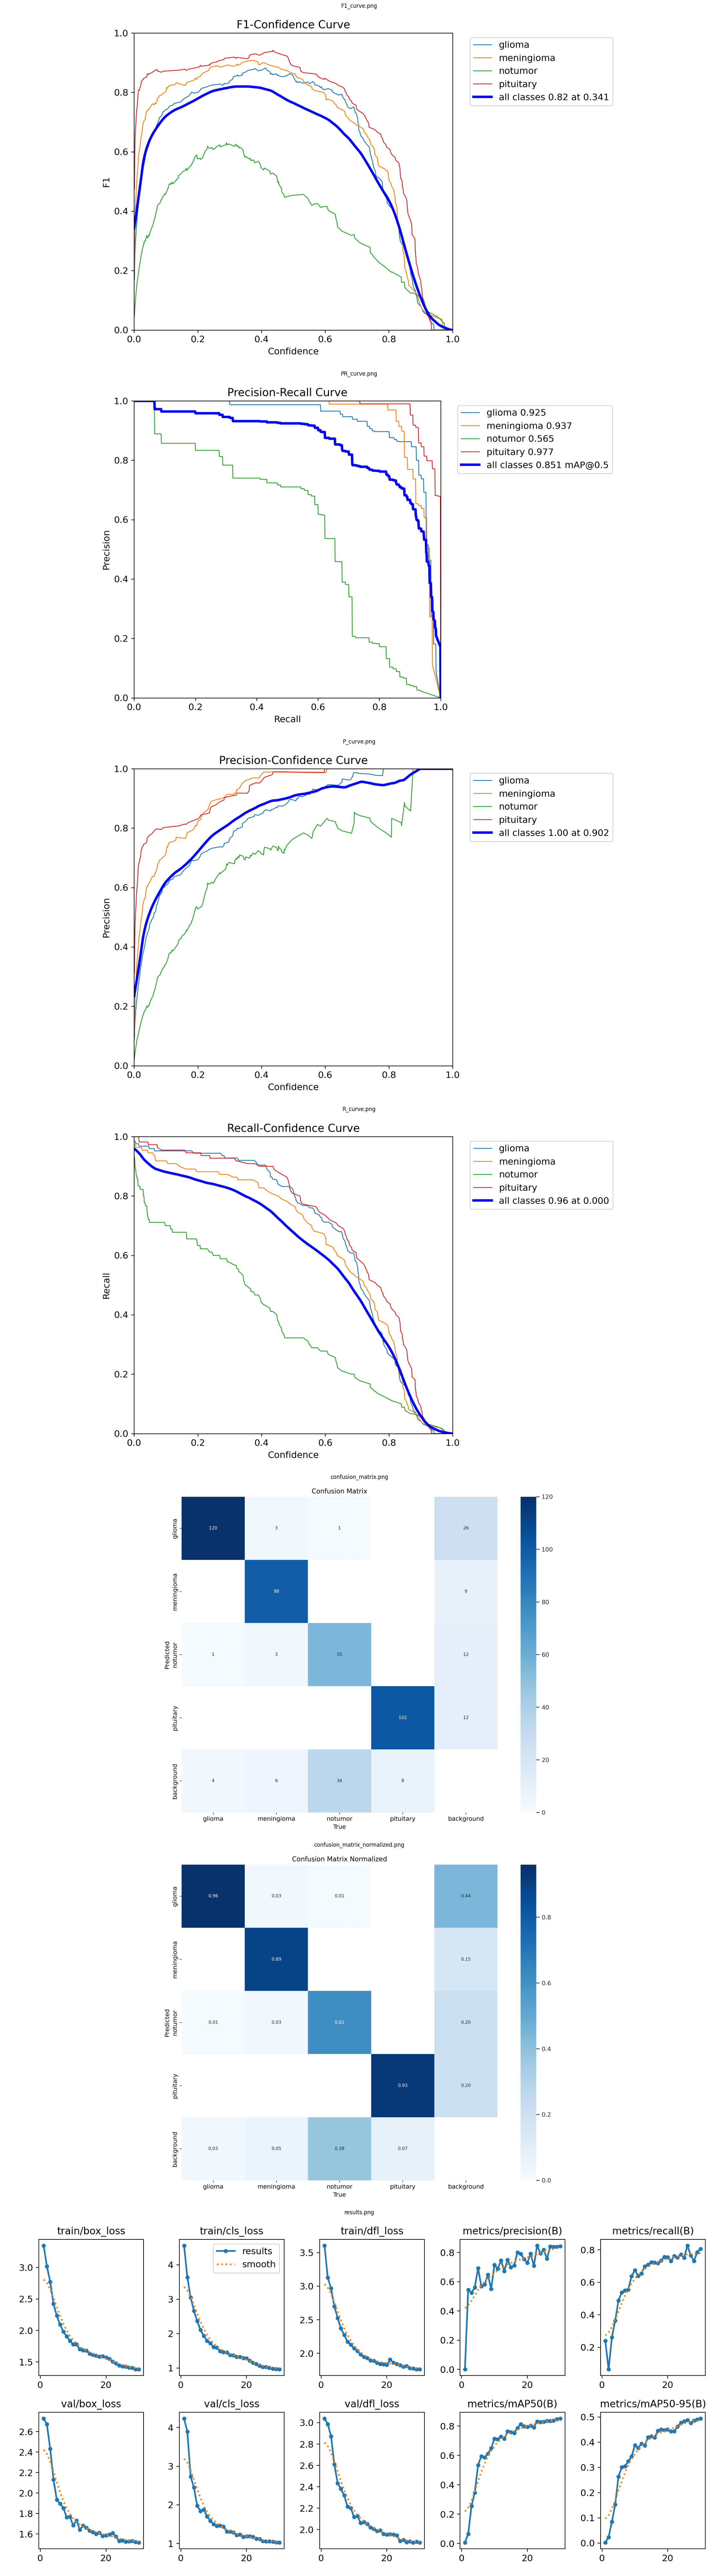

In [ ]:
image_paths = [
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/F1_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/PR_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/P_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/R_curve.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/confusion_matrix.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results_on_YOLOv8n_Adamax(test_images_dir):
    model = YOLO('/content/drive/MyDrive/brain_tumor_object_detection/yolov8n_Adamax/detect/YOLOv8n_Adamax/weights/best.pt')

    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)
        model.predict(image_path, save=True, imgsz=512, conf=0.3)

In [ ]:
test_dir = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images'
predict_results_on_YOLOv8m_Adam(test_dir)


image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Copy of Tr-gl_0045.jpg: 512x512 1 notumor, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Copy of Tr-gl_0037.jpg: 512x512 1 notumor, 18.7ms
Speed: 1.5ms preprocess, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Copy of Tr-gl_0029.jpg: 512x512 (no detections), 23.3ms
Speed: 1.6ms preprocess, 23.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict

image 1/1 /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test_images/Copy of Tr

In [54]:
def display_images(images, num_images_per_row=5):
    fig, axs = plt.subplots(len(images) // num_images_per_row, num_images_per_row, figsize=(30, 30))
    axs = axs.flatten()

    for i, img_path in enumerate(images):
        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

In [55]:
def get_random_images_from_dir(directory, num_images=5):
    all_images = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    random_images = random.sample(all_images, min(num_images, len(all_images)))
    return [os.path.join(directory, img) for img in random_images]

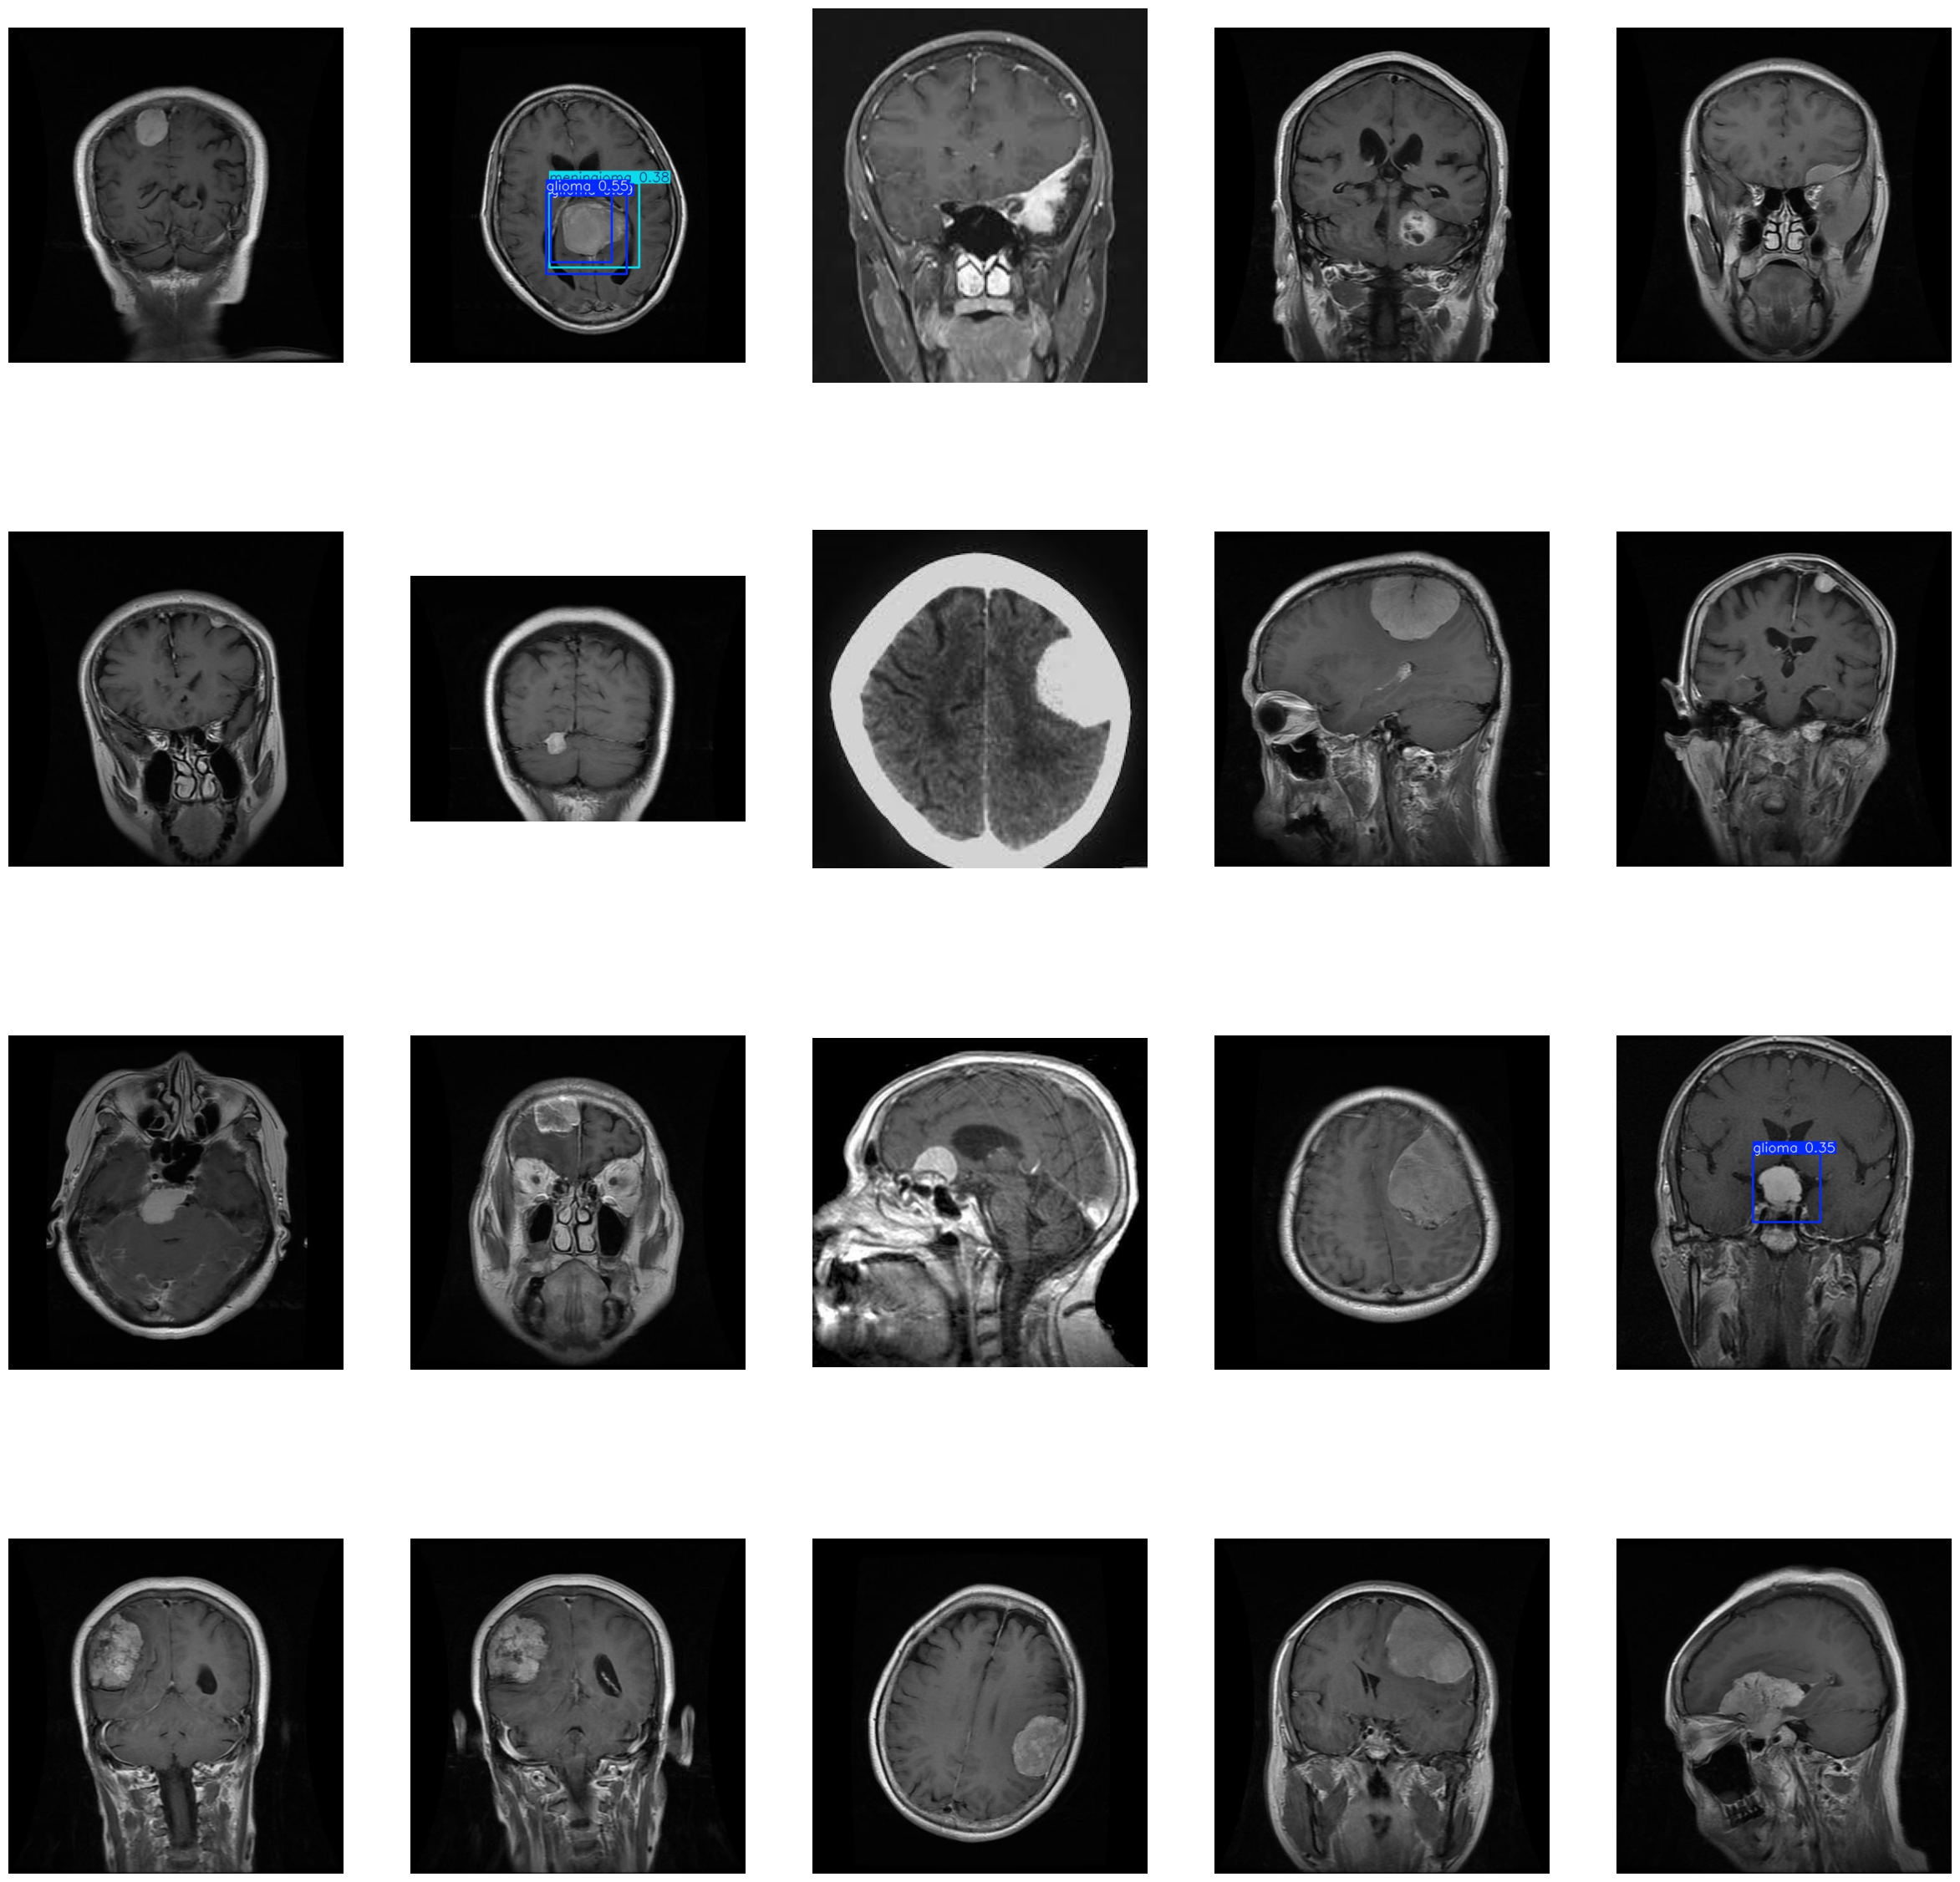

In [59]:
random_images = get_random_images_from_dir('./runs/detect/predict2', 20)
display_images(random_images)